# Domača naloga 1: Inverzna potenčna metoda za tridiagonalno matriko

<ins>**Avtor:**</ins> Žiga Leskovec 

<ins>**Datum:**</ins> 13. 4. 2024

In [1]:
using Revise
using Domaca01

Precompiling Domaca01
  ✓ Domaca01
  1 dependency successfully precompiled in 1 seconds. 153 already precompiled.


## Uvod

V domači nalogi je bilo potrebno izvedeti implementacijo inverzne potenčne metode za iskanje lastnih vrednosti matrike za tridiagonalne matrike.

Prvi del poročila predstavlja opis implementacije nove podatkovne strukture `Tridiagonalna` in funkcijo `tridiag`.
Nadaljuje s krajšim opisom dveh podstruktur `ZgornjaTridiagonalna` in `SpodnjaTridiagonalna` in opisom implementacij osnovnih funkcij, kot so `lu` in operator `\`.

V drugem delu se osredotočimo na inverzno potenčno metodo.
Podan je grob opis splošne metode in kakšne posebnosti se pojavijo ko jo uporabimo na simetričnih matrikah.

Na koncu predstavimo uporabo inverzne iteracije pri iskanju lastnih vrednosti na primeru laplaceove matrike. 

## Simetrične matrike in tridiagonalizacija

### Matrika $T$

Poljubno simetrično matriko $A$ lahko preoblikujemo v tridiagonalno matriko $T$.
Ta je definirana na naslednji način:
$$
T = Q^T A Q
$$

Ker je matrika $A$ simetrična je simetrična tudi matrika $T$.


### Podatkovni tip `Tridiagonalna`

Implementacija strukture `Tridiagonalna` je preprosta.
Ker je matrika $T$ simetrična je ta sestavljena iz dveh vektorjev.
Prvi predstavja diagonalo, drugi pa predstavlja nad-diagonalo (diagonala nad sredinsko diagonalo) in pod-diagonalo (diagonala pod sredinsko diagonalo).


### Funkcija `tridiag`

Funkcija `T, Q = tridiag(A)` omogoča pridobitev tridiagonalnih matrik iz poljubnih simetričnih.
Da pridobimo tridiagonalno matriko moramo eleminirati vse elemente, ki ležijo pod pod-diagonalo.
To dosežemo z uporabo Householderjevimi zrcaljenji na enak način kot pri Hassenbergovem razcepu.

Za vsak del stolpca matrike $A$, ki je pod diagonalo, poiščemo vektor $u$ preko katerega se prezrcali v vektor kolinearen vektorju $e_1 = [1,0,\dots]$

$$
\hat{u} = A^{(k)}_{k:n,k} + sgn(A^{(k)}_{k+1,k}) \cdot || A^{(k)}_{k+1,k} ||_2  e_1
$$

Funkcija $sgn$ predstavlja posebno različico funkcije $sign$, ki pri ničli vrne število 1.
Uporabimo jo za izboljšavo stabilnosti Hassenbergovega razcepa.
Z uporabo normaliziranega vektorja $u$ lahko izračunamo matriko $A^{(k+1)}$ na naslednji način:

$$
A^{(k+1)} = Q^{(k)} A^{(k)} Q^{(k)}
$$

kjer

$$
Q^{(k)} = I_{n-k} ⊕ (I_k - 2uu^T)
$$

Skozi celoten postopek gradimo matriko $Q = Q_1Q_2\dots Q_k \dots Q_n$.

In [2]:
# Primer simetrične matrike in njegove tridiagonalno podobne matrike
A = [  4  1 -2  2
    ;  1  2  0  1
    ; -2  0  3 -2
    ;  2  1 -2 -1
    ]

T, Q = tridiag(A)
to_matrix(T)

4×4 Matrix{Float64}:
  4.0  -3.0       0.0       0.0
 -3.0   3.33333  -1.66667   0.0
  0.0  -1.66667  -1.32      0.906667
  0.0   0.0       0.906667  1.98667

In [3]:
isapprox(T, Q' * A * Q) # Q^T A Q ≈ T

true

## LU razcep

Osnoven algoritem za LU razcep uporabi Gaussove eleminacije za preoblikovanje originalne matrike v zgornje trikotno in shrani eleminacijsko matriko kot spodnje trikotno.
Tipično tak algoritem ima kompleksnost $O(n^3)$, kar je razvidno iz uporabe treh `for`-zank.

Če specializiramo tak algoritem za tridiagonalne matrike, se ta kompleksnost spusti na $O(n)$, saj ne potrebujemo eleminirati vse elemente pod diagonalo, ker imajo vsi razen enega že vrednost 0.


## Strukturi `SpodnjaTridiagonalna` in `ZgornjaTridiagonalna`

Kot rezultat posebnega LU razcepa dobimo spodnje tridiagonalno iz zgornjo tridiagonalno matriko, kateri vsebujeti samo dve diagonali in posledično s tem drastično zmanjšamo uporabo pomnilnika.

Za ta dva tipa se tudi drastično spusti kompleksnost funkcije za reševanje sistema enačb (`Base.\`).
Ker vsebujeta ti dve matriki zgolj dve diagonali, je pri reševanju potreben samo postopek obratnega (za zgornjo tridiagonalno) in navadnega (za spodnjo tridiagonalno) vstavljanja.


In [4]:
T = Tridiagonalna{Float64}([1; 2; 3], [4; 5])
L, U = lu(T)
to_matrix(L)

3×3 Matrix{Float64}:
 1.0   0.0       0.0
 4.0   1.0       0.0
 0.0  -0.357143  1.0

In [5]:
to_matrix(U)

3×3 Matrix{Float64}:
 1.0    4.0  0.0
 0.0  -14.0  5.0
 0.0    0.0  4.78571

In [6]:
L * (L \ [1.0,2.0,3.0])

3-element Vector{Float64}:
 1.0
 2.0
 3.0

## Inverzna potenčna metoda

Inverzna potenčna metoda nam omogoča računanje lastnih vektorjev s približki lastnih vrednosti.
Začnemo z naključnim vektorjem.
Naslednjo iteracijo iračunamo na naslednji način

$$
x^{(n+1)} = \frac{(A - \lambda I)^{-1} x^{(n)}}{||(A - \lambda I)^{-1} x^{(n)}||}
$$

Namesto da uporabimo splošen algoritem, ga preuredimo za simetrične matrike.
Funkcija sprejme simetrično matriko $A$ in približek lastnega vektorja $\lambda$.
Začnemo s Hassenbergovim razcepom (tridiagonalizacija matrike) s katerim pridobimo matriki $Q$ in $T$.
Nad matriko $T$ naredimo LU razcep in tega uporabimo za računanje iteracij: $L(Ux^{(n+1)}) = x^{(n)}$.
Ko razlika $Tx - \lambda x$ se spusti pod toleranco, vrnemo konvergirano lastno vrednost in vektor $x$ katerega pred tem transformiramo z matriko $Q$, saj sam vektor $x$ predstavlja lastni vektor za matriko $T$ in ne za željeno matriko $A$.

In [7]:
λ, v = inv_lastni(A, 1)

(1.084364463787609, [1.0, -0.84730147047051, 0.8099863691875322, -0.22418066368340855])

In [8]:
isapprox(λ*v, A*v)

true

## Računanje lastnih vrednosti za Laplaceovo matriko

Podana je Laplaceova matrika $l$.
Ta je tridiagonalna in definirana na naslednji način: $l_{ii} = -2$ in $l_{i+1,j} = l_{i,j+1} = 1$

In [9]:
laplace(n) = Tridiagonalna([-2.0 for _ in 1:n], ones(n-1))

laplace (generic function with 1 method)

In [10]:
to_matrix(laplace(5))

5×5 Matrix{Float64}:
 -2.0   1.0   0.0   0.0   0.0
  1.0  -2.0   1.0   0.0   0.0
  0.0   1.0  -2.0   1.0   0.0
  0.0   0.0   1.0  -2.0   1.0
  0.0   0.0   0.0   1.0  -2.0

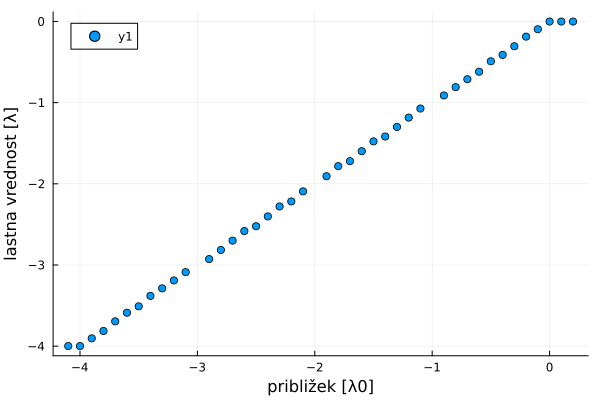

In [85]:
using Plots

l = to_matrix(laplace(100))
λvs = [ (i, x[1], x[2]) 
        for i in -5:0.1:1
        for x in (inv_lastni(l, i,1000),) 
            if x != nothing ]
xs = [ i for (i, _, _) in λvs ]
λs = [ λ for (_, λ, _) in λvs ]
vs = [ v for (_, _, v) in λvs ]

plot(xs, λs, seriestype=:scatter, xlabel="približek [λ0]", ylabel="lastna vrednost [λ]")

Lastni vektorji matrike $l$ so priblici za rešitev robnega problema za diferencialno enačbo

$$
y''(x) = \lambda^2y(x)
$$

katere rešitve sta finkciji $\sin(\lambda x)$ in $\cos(\lambda x)$

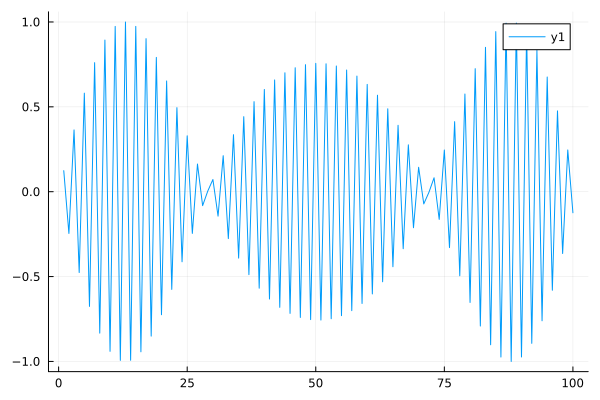

In [88]:
plot(sin.(λs[1]*vs[1]))

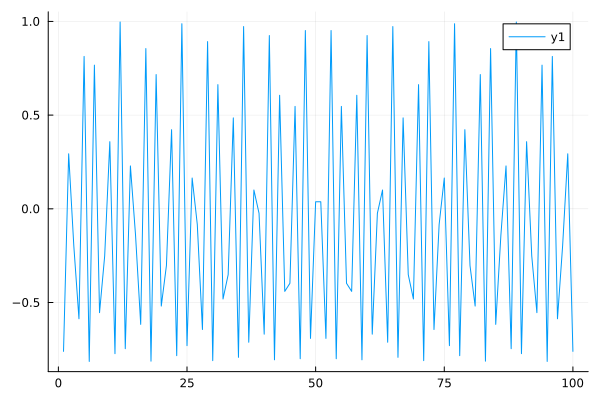

In [100]:
plot(cos.(λs[16]*vs[16]))